In [32]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices
!nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q
!lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
!free -h --si | awk  '/Mem:/{print $2}'

# if use tpu
# import tensorflow as tf
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

/bin/bash: /tmp/ENTER/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sat Nov 19 17:50:39 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:2D:00.0 Off |                  Off |
| 30%   37C    P8    22W / 230W |  22715MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+------

In [33]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=28)
mpl.rc('xtick', labelsize=24)
mpl.rc('ytick', labelsize=24)

import math
import time 
# from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

In [34]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')]

In [35]:
is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
print(is_gpu)

True


# CFD Parameters

In [36]:
dt = 0.5
dx = 1.0
dy = 1.0
dz = 1.0
Re = 1/20
ub = 1
nx = 512
ny = 512
nz = 128
ratio = int(nx/nz)
nlevel = int(math.log(nz, 2)) + 1 
print('Levels of Multigrid:', nlevel)
print('Aspect ratio of Domain:', ratio)

Levels of Multigrid: 8
Aspect ratio of Domain: 4


# Weights of CNNs layers

In [37]:
diffusion = np.loadtxt('diffusion.csv', delimiter = ',')
advx = np.loadtxt('advection_x.csv', delimiter = ',')
advy = np.loadtxt('advection_y.csv', delimiter = ',')
advz = np.loadtxt('advection_z.csv', delimiter = ',')

In [38]:
D = -diffusion/dx**2
adv_x = advx/dx*0.5
adv_y = advy/dy*0.5
adv_z = advz/dz*0.5
A_mg = diffusion/dx**2

In [39]:
# adv_x = np.zeros([1,5,5,5,1])
# adv_xx = np.zeros([1,5,5,5,1])

# adv_y = np.zeros([1,5,5,5,1])
# adv_z = np.zeros([1,5,5,5,1])
# D = np.zeros([1,5,5,5,1])
# A_mg = np.zeros([1,5,5,5,1])

# for i in range(5):
#     print(i,i*5,(i+1)*5)
#     adv_x[0,i,:,:,0] = advx[i*5:(i+1)*5,0]*dt

# adv_x
w_res = np.zeros([1,2,2,2,1])
w_res[0,:,:,:,0] = 0.125

In [40]:
p_div_x1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
p_div_x2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
p_div_x3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

p_div_y1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
p_div_y2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
p_div_y3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

p_div_z1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
p_div_z2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
p_div_z3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w2 = np.zeros([1,3,3,3,1])
w3 = np.zeros([1,3,3,3,1])
w4 = np.zeros([1,3,3,3,1])

w2[0,0,:,:,0] = np.array(p_div_x1)/dx
w2[0,1,:,:,0] = np.array(p_div_x2)/dx
w2[0,2,:,:,0] = np.array(p_div_x3)/dx

w3[0,0,:,:,0] = np.array(p_div_y1)/dx
w3[0,1,:,:,0] = np.array(p_div_y2)/dx
w3[0,2,:,:,0] = np.array(p_div_y3)/dx 

w4[0,0,:,:,0] = np.array(p_div_z1)/dx 
w4[0,1,:,:,0] = np.array(p_div_z2)/dx
w4[0,2,:,:,0] = np.array(p_div_z3)/dx

In [41]:
kernel_initializer_D = tf.keras.initializers.constant(D)
kernel_initializer_adv_x = tf.keras.initializers.constant(adv_x)
kernel_initializer_adv_y = tf.keras.initializers.constant(adv_y)
kernel_initializer_adv_z = tf.keras.initializers.constant(adv_z)
kernel_initializer_w_res = tf.keras.initializers.constant(w_res)
kernel_initializer_A_mg = tf.keras.initializers.constant(A_mg)

kernel_initializer_adv_x_3 = tf.keras.initializers.constant(w2)
kernel_initializer_adv_y_3 = tf.keras.initializers.constant(w3)
kernel_initializer_adv_z_3 = tf.keras.initializers.constant(w4)

bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# Libraries for solving momentum equation

In [42]:
central_xadv_3th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_x_3,
                                bias_initializer=bias_initializer),
])

central_yadv_3th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_y_3,
                                bias_initializer=bias_initializer),
])

central_zadv_3th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_z_3,
                                bias_initializer=bias_initializer),
])

In [43]:
central_dif_5th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_D,
                                bias_initializer=bias_initializer),
])

central_xadv_5th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_x,
                                bias_initializer=bias_initializer),
])

central_yadv_5th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_y,
                                bias_initializer=bias_initializer),
])

central_zadv_5th = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nz, ny, nx, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_adv_z,
                                bias_initializer=bias_initializer),
])

# Libraries for multigrid algorithms

In [44]:
for i in range(nlevel):
    locals()['CNN3D_A_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-1-i)), int(ny*0.5**(nlevel-1-i)), int(nx*0.5**(nlevel-1-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=5, strides=1, padding='SAME',         
                                kernel_initializer=kernel_initializer_A_mg,
                                bias_initializer=bias_initializer)
    ])

In [45]:
for i in range(nlevel-1):
    locals()['restrict_'+str(2**(i+1))] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(int(nz*0.5**(nlevel-2-i)), int(ny*0.5**(nlevel-2-i)), int(nx*0.5**(nlevel-2-i)), 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_w_res,
                                bias_initializer=bias_initializer),   
    ])    

In [46]:
for i in range(nlevel-1):
    locals()['prolongate_'+str(2**i)] = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1*2**i, 1*ratio*2**i, 1*ratio*2**i, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
    ])

# Functions linking to the AI libraries

In [47]:
def boundary_condition_velocity(values_u,values_v,values_w):
    'Define boundary conditions for velocity field'
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)   
    tempw = tf.Variable(values_w) 
    tempu[0,:,:,0:2,0].assign(tf.Variable(tf.ones((nz,ny,2)))[0,:]*ub) 
    tempv[0,:,:,0:2,0].assign(tf.Variable(tf.zeros((nz,ny,2)))[0,:])    
    tempw[0,:,:,0:2,0].assign(tf.Variable(tf.zeros((nz,ny,2)))[0,:])    

    tempu[0,:,:,nx-2:nx,0].assign(tf.Variable(tf.ones((nz,ny,2)))[0,:]*ub) 
    tempv[0,:,:,nx-2:nx,0].assign(tf.Variable(tf.zeros((nz,ny,2)))[0,:])   
    tempw[0,:,:,nx-2:nx,0].assign(tf.Variable(tf.zeros((nz,ny,2)))[0,:])  
    
    tempu[0,:,0,:,0].assign(tf.Variable(values_u)[0,:,2,:,0]) 
    tempu[0,:,1,:,0].assign(tf.Variable(values_u)[0,:,2,:,0]) 
    tempv[0,:,0:2,:,0].assign(tf.Variable(tf.zeros((nz,2,nx)))[0,:])  
    tempw[0,:,0:2,:,0].assign(tf.Variable(tf.zeros((nz,2,nx)))[0,:])  
        
    tempu[0,:,nx-1,:,0].assign(tf.Variable(values_u)[0,:,nx-3,:,0])    
    tempu[0,:,nx-2,:,0].assign(tf.Variable(values_u)[0,:,nx-3,:,0])    
    tempv[0,:,nx-2:nx,:,0].assign(tf.Variable(tf.zeros((nz,2,nx)))[0,:])     
    tempw[0,:,nx-2:nx,:,0].assign(tf.Variable(tf.zeros((nz,2,nx)))[0,:])  
    
    tempu[0,0:2,:,:,0].assign(tf.Variable(tf.zeros((2,ny,nx)))[0,:])     
    tempv[0,0:2,:,:,0].assign(tf.Variable(tf.zeros((2,ny,nx)))[0,:])  
    tempw[0,0:2,:,:,0].assign(tf.Variable(tf.zeros((2,ny,nx)))[0,:])  
 
    tempu[0,nz-1,:,:,0].assign(tf.Variable(values_u)[0,nz-3,:,:,0])   
    tempu[0,nz-2,:,:,0].assign(tf.Variable(values_u)[0,nz-3,:,:,0])       
    tempv[0,nz-1,:,:,0].assign(tf.Variable(values_v)[0,nz-3,:,:,0]) 
    tempv[0,nz-2,:,:,0].assign(tf.Variable(values_v)[0,nz-3,:,:,0])       
    tempw[0,nz-2:nz,:,:,0].assign(tf.Variable(tf.zeros((2,ny,nx)))[0,:])      
    return tempu,tempv,tempw

def boundary_condition_pressure(values_p,nx):
    'Define boundary conditions for pressure field'
    tempp = tf.Variable(values_p)   
    tempp[0,:,:,nx-2:nx,0].assign(tf.Variable(tf.zeros((nz,ny,2)))[0,:]) 
    tempp[0,:,:,0,0].assign(tf.Variable(values_p)[0,:,:,2,0]) 
    tempp[0,:,:,1,0].assign(tf.Variable(values_p)[0,:,:,2,0])     
    
    tempp[0,:,0,:,0].assign(tf.Variable(values_p)[0,:,2,:,0]) 
    tempp[0,:,1,:,0].assign(tf.Variable(values_p)[0,:,2,:,0])     
    tempp[0,:,nx-1,:,0].assign(tf.Variable(values_p)[0,:,nx-3,:,0])  
    tempp[0,:,nx-2,:,0].assign(tf.Variable(values_p)[0,:,nx-3,:,0]) 

    
    tempp[0,0,:,:,0].assign(tf.Variable(values_p)[0,2,:,:,0]) 
    tempp[0,1,:,:,0].assign(tf.Variable(values_p)[0,2,:,:,0])     
    tempp[0,nz-1,:,:,0].assign(tf.Variable(values_p)[0,nz-3,:,:,0])    
    tempp[0,nz-2,:,:,0].assign(tf.Variable(values_p)[0,nz-3,:,:,0]) 
#     tempp[0,:,:,0:2,0].assign(tf.Variable(values_p)[0,:,:,2,0])
    
#     tempp[0,:,0:2,:,0].assign(tf.Variable(values_p)[0,:,2,:,0])     
#     tempp[0,:,nx-2:nx,:,0].assign(tf.Variable(values_p)[0,:,nx-3,:,0]) 
    
#     tempp[0,0:2,:,:,0].assign(tf.Variable(values_p)[0,2,:,:,0])     
#     tempp[0,nz-2:nz,:,:,0].assign(tf.Variable(values_p)[0,nz-3,:,:,0])  
    return tempp

def boundary_condition_indicator(alpha,nx):   
    'Define boundary conditions for scalar field'
    tempa = tf.Variable(alpha)   
    tempa[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    tempa[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])
    
    tempa[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    
    tempa[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempa[0,nx-1,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    return tempa

def boundary_condition_source(b,nx):  
    'Define inflow boundary conditions for source terms to'
    'avoid incorrect paddings caused by CNNs'
    tempb = tf.Variable(b)   
    tempb[0,:,:,0,0].assign(tf.Variable(b)[0,:,:,2,0])
    tempb[0,:,:,1,0].assign(tf.Variable(b)[0,:,:,2,0])

    return tempb

def bluff_body(values_u,values_v,values_w,sigma):
    'Immersed Boundary for buildings'
    temp1 = values_u / (1+dt*sigma) 
    temp2 = values_v / (1+dt*sigma)
    temp3 = values_w / (1+dt*sigma) 
    return temp1,temp2,temp3

def save_data(n_out,itime):
    'Save field data'
    if itime % n_out == 0:  
        np.save("../Data_Results/INHALE_512_555_3/u"+str(itime), arr=values_u[0,:,:,:,0])
        np.save("../Data_Results/INHALE_512_555_3/v"+str(itime), arr=values_v[0,:,:,:,0])
        np.save("../Data_Results/INHALE_512_555_3/w"+str(itime), arr=values_w[0,:,:,:,0])
        np.save("../Data_Results/INHALE_512_555_3/p"+str(itime), arr=values_p[0,:,:,:,0])

In [48]:
def Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_x: Final diffusion matrix in x direction 
    k_y: Final diffusion matrix in y direction 
    k_z: Final diffusion matrix in z direction 
    '''
    values_u = values_u / (1+dt*sigma) 
    values_v = values_v / (1+dt*sigma)     
    values_w = values_w / (1+dt*sigma) 
      
    k_u = 0.4 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               central_dif_5th(values_u)) / (eplsion_k + 
                               (abs(central_xadv_5th(values_u)) + 
                               abs(central_yadv_5th(values_u)) + 
                               abs(central_zadv_5th(values_u)))/3)
    
    k_v = 0.4 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               central_dif_5th(values_v)) / (eplsion_k + 
                               (abs(central_xadv_5th(values_v)) + 
                               abs(central_yadv_5th(values_v)) + 
                               abs(central_zadv_5th(values_v)))/3)
    
    k_w = 0.4 * 0.25 * abs(1/3*
                               (abs(values_u) + abs(values_v) + abs(values_w)) * 
                               central_dif_5th(values_w)) / (eplsion_k + 
                               (abs(central_xadv_5th(values_w)) + 
                               abs(central_yadv_5th(values_w)) + 
                               abs(central_zadv_5th(values_w)))/3)
       
    k_u = tf.math.minimum(k_u, tf.ones(input_shape)/dt*0.25*2) / (1+dt*sigma) 
    k_v = tf.math.minimum(k_v, tf.ones(input_shape)/dt*0.25*2) / (1+dt*sigma)     
    k_w = tf.math.minimum(k_w, tf.ones(input_shape)/dt*0.25*2) / (1+dt*sigma)    
    
    
    k_x = 3*0.5*(k_u*central_dif_5th(values_u) +
                central_dif_5th(values_u*k_u) -
                values_u*central_dif_5th(k_u))


    k_y = 3*0.5*(k_v*central_dif_5th(values_v) + 
                central_dif_5th(values_v*k_v) -
                values_v*central_dif_5th(k_v))


    k_z = 3*0.5*(k_w*central_dif_5th(values_w) + 
                central_dif_5th(values_w*k_w) -
                values_w*central_dif_5th(k_w))

    return k_x, k_y, k_z

In [49]:
def Petrov_Galerkin_dissipation_high(values_u, values_v, values_w, eplsion_k, sigma):    
    '''Turbulence modelling using Petrov-Galerkin dissipation       
    Input
    ---------------------------------------------------------------------
    values_u: u-component velocity 
    values_v: v-component velocity 
    values_w: w-component velocity 
    eplsion_k: Need to sufficiently large
    
    Output
    ---------------------------------------------------------------------
    k_x: Final diffusion matrix in x direction 
    k_y: Final diffusion matrix in y direction 
    k_z: Final diffusion matrix in z direction 
    '''
    values_u = values_u / (1+dt*sigma) 
    values_v = values_v / (1+dt*sigma)     
    values_w = values_w / (1+dt*sigma) 
      
    k_u = 8*0.25*abs(values_u*(central_xadv_5th(values_u)-central_xadv_3th(values_u))+
                     values_v*(central_yadv_5th(values_u)-central_yadv_3th(values_u))+
                     values_w*(central_zadv_5th(values_u)-central_zadv_3th(values_u)))/ \
                     (eplsion_k+(abs(central_xadv_5th(values_u))+ \
                      abs(central_yadv_5th(values_u))+abs(central_zadv_5th(values_u)))/3)

    k_v = 8*0.25*abs(values_u*(central_xadv_5th(values_v)-central_xadv_3th(values_v))+
                     values_v*(central_yadv_5th(values_v)-central_yadv_3th(values_v))+
                     values_w*(central_zadv_5th(values_v)-central_zadv_3th(values_v)))/ \
                     (eplsion_k+(abs(central_xadv_5th(values_v))+ \
                      abs(central_yadv_5th(values_v))+abs(central_zadv_5th(values_v)))/3)
    
    k_w = 8*0.25*abs(values_u*(central_xadv_5th(values_w)-central_xadv_3th(values_w))+
                     values_v*(central_yadv_5th(values_w)-central_yadv_3th(values_w))+
                     values_w*(central_zadv_5th(values_w)-central_zadv_3th(values_w)))/ \
                     (eplsion_k+(abs(central_xadv_5th(values_w))+ \
                      abs(central_yadv_5th(values_w))+abs(central_zadv_5th(values_w)))/3)
    
    
    
    
#     k_v = 40 * 0.25 * abs(1/3*
#                                (abs(values_u) + abs(values_v) + abs(values_w)) * 
#                                central_dif_5th(values_v)) / (eplsion_k + 
#                                (abs(central_xadv_5th(values_v)) + 
#                                abs(central_yadv_5th(values_v)) + 
#                                abs(central_zadv_5th(values_v)))/3)
    
#     k_w = 40 * 0.25 * abs(1/3*
#                                (abs(values_u) + abs(values_v) + abs(values_w)) * 
#                                central_dif_5th(values_w)) / (eplsion_k + 
#                                (abs(central_xadv_5th(values_w)) + 
#                                abs(central_yadv_5th(values_w)) + 
#                                abs(central_zadv_5th(values_w)))/3)
       
    k_u = tf.math.minimum(k_u, tf.ones(input_shape)/dt*0.25) / (1+dt*sigma) 
    k_v = tf.math.minimum(k_v, tf.ones(input_shape)/dt*0.25) / (1+dt*sigma)     
    k_w = tf.math.minimum(k_w, tf.ones(input_shape)/dt*0.25) / (1+dt*sigma)    
    
    
    k_x = 3*0.5*(k_u*central_dif_5th(values_u) +
                central_dif_5th(values_u*k_u) -
                values_u*central_dif_5th(k_u))


    k_y = 3*0.5*(k_v*central_dif_5th(values_v) + 
                central_dif_5th(values_v*k_v) -
                values_v*central_dif_5th(k_v))


    k_z = 3*0.5*(k_w*central_dif_5th(values_w) + 
                central_dif_5th(values_w*k_w) -
                values_w*central_dif_5th(k_w))

    return k_x, k_y, k_z

# Initialise

============== Numerical parameters ===============
Mesh resolution: (1, 128, 512, 512, 1)
Time step: 7000
Initial time: 0
Solving single-phase flows!
Switch on IBM solver!


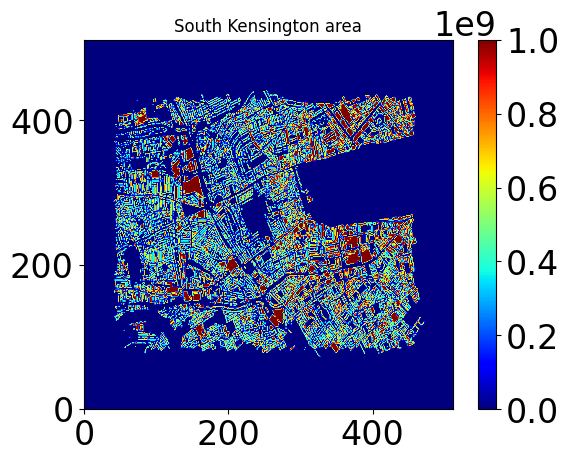

In [50]:
#################### Create field #####£###############
input_shape = (1,nz,ny,nx,1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)
#######################################################
################# Numerical parameters ################
multi_itr = 4               # Iterations of multi-grid 
j_itr = 1                   # Iterations of Jacobi 
ntime = 7000                 # Time steps
n_out = 1000                 # Results output
nrestart = 0                # Last time step for restart
ctime_old = 0               # Last ctime for restart
mgsolver = True             # Multigrid solver
LSCALAR = False              # Scalar transport 
LMTI = False                 # Non density for multiphase flows
LIBM = True                # Immersed boundary method 
nsafe = 0.5                 # Continuty equation residuals
ctime = 0                   # Initialise ctime   
save_fig = False             # Save results
Restart = False             # Restart
eplsion_k = 1e-03
################# Physical parameters #################
rho_l = 1000                # Density of liquid phase 
rho_g = 980                 # Density of gas phase 
g_x = 0;g_y = 0;g_z = -9.8   # Gravity acceleration (m/s2) 
#######################################################
print('============== Numerical parameters ===============')
print('Mesh resolution:', values_v.shape)
print('Time step:', ntime)
print('Initial time:', ctime)
#######################################################
################# Only for restart ####################
if Restart == True:
    temp1 = np.load('../Data_Results/data_SK_quartic/u500.npy').astype('float32')
    temp2 = np.load('../Data_Results/data_SK_quartic/v500.npy').astype('float32')
    temp3 = np.load('../Data_Results/data_SK_quartic/w500.npy').astype('float32')
    temp4 = np.load('../Data_Results/data_SK_quartic/p500.npy').astype('float32')
    values_u = tf.Variable(values_u)[0,:,:,:,0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0,:,:,:,0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0,:,:,:,0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0,:,:,:,0].assign(tf.convert_to_tensor(temp4))
    nrestart = 500
    ctime_old = nrestart*dt
    print('Restart solver!')
#######################################################    
################# Only for scalar #####################
if LSCALAR == True:
    alpha = np.zeros(input_shape).astype('float32')
    alpha[0,0:64,:,:,0] = 0
    alpha[0,64:128,:,:,0] = 1.0
    alpha = tf.convert_to_tensor(alpha)
    print('Switch on scalar filed solver!')
#######################################################
################# Only for scalar #####################
if LMTI == True:
    rho = tf.zeros(input_shape)
    rho = alpha*rho_l + (1-alpha)*rho_g
    print('Solving multiphase flows!')
else:
    rho = tf.ones(input_shape)
    print('Solving single-phase flows!')
################# Only for IBM ########################
if LIBM == True:
    mesh = np.load('../Mesh_SK_London/INHALE_640.npy')
    sigma = np.zeros(input_shape).astype('float32')
    for i in range(1,nx-1):
        for j in range(1,ny-1):
            for k in range(1,nz-1):
                if mesh[0][i+64][j+64][k][0] == 0:
                    sigma[0][k][j][i][0] = 1000000000  
    sigma = tf.convert_to_tensor(sigma)
    print('Switch on IBM solver!')
    print('===================================================')
    plt.imshow(sigma[0,1,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title('South Kensington area')
    plt.gca().invert_yaxis()
#######################################################

In [ ]:
#     sigma = np.zeros(input_shape).astype('float32')


In [ ]:
# # test for petrov-galerkin case 
# values = tf.zeros(input_shape)
# T = np.zeros(input_shape).astype('float32')
# T[0,54:74,54:74,54:74,0] = 1
# T = tf.convert_to_tensor(T)
# values_u = T

In [107]:
# plt.imshow((values_u)[0,64,:,:,0], cmap='RdBu')
# plt.colorbar()

In [108]:
# for t in range(100):
#     values_u = values_u - CNN3D_central_2nd_xadv(values_u)

In [109]:
# for t in range(1000):
#     values_u = values_u + CNN3D_central_2nd_dif(values_u)

In [110]:
# for t in range(100):
#     values_u = values_u + CNN3D_central_2nd_dif(values_u) - CNN3D_central_2nd_xadv(values_u)

In [111]:
# for t in range(100):
#     [k_x,k_y,k_z] = Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma)
#     values_u = values_u + k_x - CNN3D_central_2nd_xadv(values_u)

# AI-HFM Solver

In [51]:
start = time.time()
for itime in range(1,ntime+1): 
    ctime = ctime + dt 
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
    values_p = boundary_condition_pressure(values_p,nx)
# Petrov-Galerkin dissipation
    [k_x,k_y,k_z] = Petrov_Galerkin_dissipation(values_u, values_v, values_w, eplsion_k, sigma)
# Momentum equation 
    a_u = k_x*dt*Re - \
    values_u*central_xadv_5th(values_u)*dt - \
    values_v*central_yadv_5th(values_u)*dt - \
    values_w*central_zadv_5th(values_u)*dt
    b_u = 0.5*a_u + values_u
    a_v = k_y*dt*Re - \
    values_u*central_xadv_5th(values_v)*dt - \
    values_v*central_yadv_5th(values_v)*dt - \
    values_w*central_zadv_5th(values_v)*dt
    b_v = 0.5*a_v + values_v
    a_w = k_z*dt*Re - \
    values_u*central_xadv_5th(values_w)*dt - \
    values_v*central_yadv_5th(values_w)*dt - \
    values_w*central_zadv_5th(values_w)*dt 
    b_w = 0.5*a_w + values_w

    [b_u,b_v,b_w] = boundary_condition_velocity(b_u,b_v,b_w)
    [kb_x,kb_y,kb_z] = Petrov_Galerkin_dissipation(b_u, b_v, b_w, eplsion_k, sigma)

    c_u = kb_x*dt*Re - \
    b_u*central_xadv_5th(b_u)*dt - \
    b_v*central_yadv_5th(b_u)*dt - \
    b_w*central_zadv_5th(b_u)*dt
    values_u = values_u + c_u      
    c_v = kb_y*dt*Re - \
    b_u*central_xadv_5th(b_v)*dt - \
    b_v*central_yadv_5th(b_v)*dt - \
    b_w*central_zadv_5th(b_v)*dt 
    values_v = values_v + c_v
    c_w = kb_z*dt*Re - \
    b_u*central_xadv_5th(b_w)*dt - \
    b_v*central_yadv_5th(b_w)*dt - \
    b_w*central_zadv_5th(b_w)*dt 
    values_w = values_w + c_w    
# Passive tracer scalar transport
    if LSCALAR == True:
        a_t = CNN3D_central_2nd_dif(alpha) - \
        values_u*CNN3D_central_2nd_xadv(alpha) - \
        values_v*CNN3D_central_2nd_yadv(alpha) - \
        values_w*CNN3D_central_2nd_zadv(alpha)
        alpha = alpha + a_t
        alpha = boundary_condition_indicator(alpha,nx)
    if LMTI == True:
        rho = alpha*rho_l + (1-alpha)*rho_g
# IBM
#     if LIBM == True:
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# gradp            
    values_u = values_u - central_xadv_5th(values_p)*dt
    values_v = values_v - central_yadv_5th(values_p)*dt  
    values_w = values_w - central_zadv_5th(values_p)*dt     
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
# possion equation (multi-grid) A*P = Su
    b = -(central_xadv_5th(values_u) + \
          central_yadv_5th(values_v) + \
          central_zadv_5th(values_w))/dt
    b = boundary_condition_source(b,nx)
    if mgsolver == True:
        for multi_grid in range(multi_itr): 
            w_1 = tf.zeros([1,1,ratio,ratio,1])
            r = CNN3D_A_128(values_p) - b   
            r = tf.Variable(r)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:]) 
#             r_256 = CNN3D_res_512(r) 
#             r_128 = CNN3D_res_256(r_256) 
            r_64 = restrict_128(r) 
            r_32 = restrict_64(r_64) 
            r_16 = restrict_32(r_32) 
            r_8 = restrict_16(r_16) 
            r_4 = restrict_8(r_8) 
            r_2 = restrict_4(r_4) 
            r_1 = restrict_2(r_2)
            for Jacobi in range(j_itr):
                w_1 = (w_1 - CNN3D_A_1(w_1)/A_mg[12,2] + r_1/A_mg[12,2])
            w_2 = prolongate_1(w_1)             
            for Jacobi in range(j_itr):
                w_2 = (w_2 - CNN3D_A_2(w_2)/A_mg[12,2] + r_2/A_mg[12,2])
            w_4 = prolongate_2(w_2) 
            for Jacobi in range(j_itr):
                w_4 = (w_4 - CNN3D_A_4(w_4)/A_mg[12,2] + r_4/A_mg[12,2])
            w_8 = prolongate_4(w_4) 
            for Jacobi in range(j_itr):
                w_8 = (w_8 - CNN3D_A_8(w_8)/A_mg[12,2] + r_8/A_mg[12,2])
            w_16 = prolongate_8(w_8) 
            for Jacobi in range(j_itr):
                w_16 = (w_16 - CNN3D_A_16(w_16)/A_mg[12,2] + r_16/A_mg[12,2])
            w_32 = prolongate_16(w_16) 
            for Jacobi in range(j_itr):
                w_32 = (w_32 - CNN3D_A_32(w_32)/A_mg[12,2] + r_32/A_mg[12,2])
            w_64 = prolongate_32(w_32) 
            for Jacobi in range(j_itr):
                w_64 = (w_64 - CNN3D_A_64(w_64)/A_mg[12,2] + r_64/A_mg[12,2])
            w_128 = prolongate_64(w_64) 
#             for Jacobi in range(j_itr):
#                 w_128 = (w_128 - CNN3D_A_128(w_128)/w5[0,1,1,1,0] + r_128/w5[0,1,1,1,0] )
#             w_256 = CNN3D_prol_128(w_128)
#             for Jacobi in range(j_itr):
#                 w_256 = (w_256 - CNN3D_A_256(w_256)/w5[0,1,1,1,0] + r_256/w5[0,1,1,1,0] )
#             w_512 = CNN3D_prol_256(w_256)
            values_p = values_p - w_128
            values_p = tf.Variable(values_p)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nz,ny)))[0,:])         
            values_p = (values_p - CNN3D_A_128(values_p)/A_mg[12,2] + b/A_mg[12,2])          
# correct
    values_p = boundary_condition_pressure(values_p,nx)
    values_u = values_u - central_xadv_5th(values_p)*dt
    values_v = values_v - central_yadv_5th(values_p)*dt  
    values_w = values_w - central_zadv_5th(values_p)*dt      
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w)
#     if LIBM == True:
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# output   
    print('Time step:', itime) 
    print('Pressure error:', np.max(w_128), 'cty equation residual:', np.max(r))
    print('========================================================')
    if np.max(np.abs(w_128)) > nsafe:
        print('Not converged !!!!!!')
        break
    if save_fig == True:
        save_data(n_out,itime+nrestart)
end = time.time()
print('time',(end-start))

2022-11-19 17:53:05.934575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-19 17:53:06.713086: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-19 17:53:06.713971: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-19 17:53:06.713983: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-19 17:53:06.714719: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-19 17:53:06.714762: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


Time step: 1
Pressure error: 0.070810854 cty equation residual: 0.20407444
Time step: 2
Pressure error: 0.04403183 cty equation residual: 0.12610698
Time step: 3
Pressure error: 0.033226144 cty equation residual: 0.14191961
Time step: 4
Pressure error: 0.0322733 cty equation residual: 0.1554389
Time step: 5
Pressure error: 0.03255582 cty equation residual: 0.1648243
Time step: 6
Pressure error: 0.03297999 cty equation residual: 0.17133427
Time step: 7
Pressure error: 0.033401057 cty equation residual: 0.17571115
Time step: 8
Pressure error: 0.033808634 cty equation residual: 0.17972052
Time step: 9
Pressure error: 0.034203276 cty equation residual: 0.18374795
Time step: 10
Pressure error: 0.034587063 cty equation residual: 0.1876468
Time step: 11
Pressure error: 0.034951888 cty equation residual: 0.19124359
Time step: 12
Pressure error: 0.035296533 cty equation residual: 0.19448543
Time step: 13
Pressure error: 0.035620973 cty equation residual: 0.19736767
Time step: 14
Pressure error:

Pressure error: 0.031389017 cty equation residual: 0.1784411
Time step: 64
Pressure error: 0.031033123 cty equation residual: 0.176243
Time step: 65
Pressure error: 0.030678753 cty equation residual: 0.17404681
Time step: 66
Pressure error: 0.03032689 cty equation residual: 0.17186028
Time step: 67
Pressure error: 0.02997838 cty equation residual: 0.16968805
Time step: 68
Pressure error: 0.02963404 cty equation residual: 0.16834533
Time step: 69
Pressure error: 0.02929449 cty equation residual: 0.16858059
Time step: 70
Pressure error: 0.02897773 cty equation residual: 0.16879493
Time step: 71
Pressure error: 0.028983356 cty equation residual: 0.16898882
Time step: 72
Pressure error: 0.028985977 cty equation residual: 0.1691624
Time step: 73
Pressure error: 0.028985597 cty equation residual: 0.16931558
Time step: 74
Pressure error: 0.028982311 cty equation residual: 0.16944832
Time step: 75
Pressure error: 0.028976014 cty equation residual: 0.16956031
Time step: 76
Pressure error: 0.028

Time step: 125
Pressure error: 0.026012458 cty equation residual: 0.15496218
Time step: 126
Pressure error: 0.025931867 cty equation residual: 0.1544624
Time step: 127
Pressure error: 0.025851801 cty equation residual: 0.1539638
Time step: 128
Pressure error: 0.025772229 cty equation residual: 0.15346688
Time step: 129
Pressure error: 0.025693329 cty equation residual: 0.15297306
Time step: 130
Pressure error: 0.025615135 cty equation residual: 0.15247989
Time step: 131
Pressure error: 0.02553771 cty equation residual: 0.15199059
Time step: 132
Pressure error: 0.025461204 cty equation residual: 0.15150511
Time step: 133
Pressure error: 0.025385723 cty equation residual: 0.1510225
Time step: 134
Pressure error: 0.025311284 cty equation residual: 0.15054476
Time step: 135
Pressure error: 0.025238033 cty equation residual: 0.15007138
Time step: 136
Pressure error: 0.0251659 cty equation residual: 0.14960313
Time step: 137
Pressure error: 0.025095042 cty equation residual: 0.1491409
Time s

Time step: 187
Pressure error: 0.022794055 cty equation residual: 0.13414574
Time step: 188
Pressure error: 0.022760674 cty equation residual: 0.13394427
Time step: 189
Pressure error: 0.02272722 cty equation residual: 0.13374192
Time step: 190
Pressure error: 0.022693474 cty equation residual: 0.1335398
Time step: 191
Pressure error: 0.022659527 cty equation residual: 0.13333696
Time step: 192
Pressure error: 0.022625323 cty equation residual: 0.13313347
Time step: 193
Pressure error: 0.022590864 cty equation residual: 0.13292807
Time step: 194
Pressure error: 0.022556145 cty equation residual: 0.13272172
Time step: 195
Pressure error: 0.022521103 cty equation residual: 0.13251382
Time step: 196
Pressure error: 0.022485692 cty equation residual: 0.13230425
Time step: 197
Pressure error: 0.022450037 cty equation residual: 0.13209355
Time step: 198
Pressure error: 0.022414051 cty equation residual: 0.13188064
Time step: 199
Pressure error: 0.02237781 cty equation residual: 0.13166583
Ti

Time step: 249
Pressure error: 0.020593222 cty equation residual: 0.12039733
Time step: 250
Pressure error: 0.020560049 cty equation residual: 0.120192885
Time step: 251
Pressure error: 0.020526756 cty equation residual: 0.11999023
Time step: 252
Pressure error: 0.020493358 cty equation residual: 0.1197871
Time step: 253
Pressure error: 0.020459805 cty equation residual: 0.119583786
Time step: 254
Pressure error: 0.020426027 cty equation residual: 0.11938006
Time step: 255
Pressure error: 0.020392075 cty equation residual: 0.11917621
Time step: 256
Pressure error: 0.020357922 cty equation residual: 0.11897224
Time step: 257
Pressure error: 0.020323552 cty equation residual: 0.11876708
Time step: 258
Pressure error: 0.02028892 cty equation residual: 0.11856109
Time step: 259
Pressure error: 0.020254012 cty equation residual: 0.11835444
Time step: 260
Pressure error: 0.02021885 cty equation residual: 0.11814666
Time step: 261
Pressure error: 0.02018335 cty equation residual: 0.11793822
T

Time step: 311
Pressure error: 0.018311104 cty equation residual: 0.10644382
Time step: 312
Pressure error: 0.018283758 cty equation residual: 0.10626042
Time step: 313
Pressure error: 0.018257305 cty equation residual: 0.106083035
Time step: 314
Pressure error: 0.018231714 cty equation residual: 0.105911195
Time step: 315
Pressure error: 0.018207142 cty equation residual: 0.1057452
Time step: 316
Pressure error: 0.018183611 cty equation residual: 0.10558581
Time step: 317
Pressure error: 0.018161023 cty equation residual: 0.10543305
Time step: 318
Pressure error: 0.01813945 cty equation residual: 0.10528642
Time step: 319
Pressure error: 0.018118836 cty equation residual: 0.10514593
Time step: 320
Pressure error: 0.018099224 cty equation residual: 0.105012596
Time step: 321
Pressure error: 0.018080605 cty equation residual: 0.104886174
Time step: 322
Pressure error: 0.018063014 cty equation residual: 0.10476607
Time step: 323
Pressure error: 0.018046398 cty equation residual: 0.104651

Time step: 373
Pressure error: 0.017449314 cty equation residual: 0.0999962
Time step: 374
Pressure error: 0.017441431 cty equation residual: 0.09996985
Time step: 375
Pressure error: 0.017433435 cty equation residual: 0.09994357
Time step: 376
Pressure error: 0.017425342 cty equation residual: 0.09991686
Time step: 377
Pressure error: 0.017417185 cty equation residual: 0.09988919
Time step: 378
Pressure error: 0.017408952 cty equation residual: 0.09986125
Time step: 379
Pressure error: 0.017400643 cty equation residual: 0.0998333
Time step: 380
Pressure error: 0.017392265 cty equation residual: 0.09980456
Time step: 381
Pressure error: 0.017383799 cty equation residual: 0.099775515
Time step: 382
Pressure error: 0.017375318 cty equation residual: 0.09974595
Time step: 383
Pressure error: 0.017366812 cty equation residual: 0.09971641
Time step: 384
Pressure error: 0.017358284 cty equation residual: 0.0996865
Time step: 385
Pressure error: 0.017349752 cty equation residual: 0.099656336


Time step: 435
Pressure error: 0.017004699 cty equation residual: 0.09840729
Time step: 436
Pressure error: 0.016998153 cty equation residual: 0.098385684
Time step: 437
Pressure error: 0.016991537 cty equation residual: 0.09836452
Time step: 438
Pressure error: 0.016984837 cty equation residual: 0.0983427
Time step: 439
Pressure error: 0.016978078 cty equation residual: 0.09832064
Time step: 440
Pressure error: 0.016971156 cty equation residual: 0.09829857
Time step: 441
Pressure error: 0.016964175 cty equation residual: 0.09827601
Time step: 442
Pressure error: 0.01695712 cty equation residual: 0.09825305
Time step: 443
Pressure error: 0.016949974 cty equation residual: 0.09823038
Time step: 444
Pressure error: 0.016942792 cty equation residual: 0.09820689
Time step: 445
Pressure error: 0.016935477 cty equation residual: 0.09818351
Time step: 446
Pressure error: 0.016928097 cty equation residual: 0.09815971
Time step: 447
Pressure error: 0.016920624 cty equation residual: 0.09813587


Time step: 497
Pressure error: 0.016511027 cty equation residual: 0.09677794
Time step: 498
Pressure error: 0.01650303 cty equation residual: 0.096750095
Time step: 499
Pressure error: 0.016495034 cty equation residual: 0.09672284
Time step: 500
Pressure error: 0.016487077 cty equation residual: 0.09669528
Time step: 501
Pressure error: 0.016479094 cty equation residual: 0.096668
Time step: 502
Pressure error: 0.01647116 cty equation residual: 0.09664065
Time step: 503
Pressure error: 0.016463237 cty equation residual: 0.09661293
Time step: 504
Pressure error: 0.016455298 cty equation residual: 0.096586026
Time step: 505
Pressure error: 0.016447347 cty equation residual: 0.09655853
Time step: 506
Pressure error: 0.01643944 cty equation residual: 0.09653164
Time step: 507
Pressure error: 0.016431492 cty equation residual: 0.09650448
Time step: 508
Pressure error: 0.016423585 cty equation residual: 0.09647727
Time step: 509
Pressure error: 0.016415618 cty equation residual: 0.096450195
T

Time step: 559
Pressure error: 0.015988212 cty equation residual: 0.095037885
Time step: 560
Pressure error: 0.015979154 cty equation residual: 0.09500785
Time step: 561
Pressure error: 0.015970105 cty equation residual: 0.09497787
Time step: 562
Pressure error: 0.01596104 cty equation residual: 0.09494764
Time step: 563
Pressure error: 0.015951946 cty equation residual: 0.09491759
Time step: 564
Pressure error: 0.015942825 cty equation residual: 0.09488715
Time step: 565
Pressure error: 0.015933726 cty equation residual: 0.09485692
Time step: 566
Pressure error: 0.015924623 cty equation residual: 0.094826415
Time step: 567
Pressure error: 0.0159155 cty equation residual: 0.09479562
Time step: 568
Pressure error: 0.015906386 cty equation residual: 0.09476553
Time step: 569
Pressure error: 0.015897272 cty equation residual: 0.09473448
Time step: 570
Pressure error: 0.015888175 cty equation residual: 0.094704464
Time step: 571
Pressure error: 0.015879072 cty equation residual: 0.09467437

Time step: 621
Pressure error: 0.015419421 cty equation residual: 0.09312814
Time step: 622
Pressure error: 0.015409818 cty equation residual: 0.093096726
Time step: 623
Pressure error: 0.015400199 cty equation residual: 0.093064316
Time step: 624
Pressure error: 0.015390583 cty equation residual: 0.09303252
Time step: 625
Pressure error: 0.0153809525 cty equation residual: 0.09300059
Time step: 626
Pressure error: 0.015371335 cty equation residual: 0.09296856
Time step: 627
Pressure error: 0.015361691 cty equation residual: 0.092936486
Time step: 628
Pressure error: 0.01535209 cty equation residual: 0.09290428
Time step: 629
Pressure error: 0.015342428 cty equation residual: 0.0928722
Time step: 630
Pressure error: 0.015332764 cty equation residual: 0.09283988
Time step: 631
Pressure error: 0.015323123 cty equation residual: 0.09280713
Time step: 632
Pressure error: 0.01531348 cty equation residual: 0.09277508
Time step: 633
Pressure error: 0.015303828 cty equation residual: 0.0927426

Pressure error: 0.014826587 cty equation residual: 0.09106436
Time step: 683
Pressure error: 0.014816711 cty equation residual: 0.091029674
Time step: 684
Pressure error: 0.014806805 cty equation residual: 0.09099477
Time step: 685
Pressure error: 0.014796933 cty equation residual: 0.09095989
Time step: 686
Pressure error: 0.014787017 cty equation residual: 0.090925306
Time step: 687
Pressure error: 0.01477712 cty equation residual: 0.09089056
Time step: 688
Pressure error: 0.014767202 cty equation residual: 0.09085554
Time step: 689
Pressure error: 0.014757308 cty equation residual: 0.09082086
Time step: 690
Pressure error: 0.014747394 cty equation residual: 0.09078584
Time step: 691
Pressure error: 0.014737487 cty equation residual: 0.09075113
Time step: 692
Pressure error: 0.01472758 cty equation residual: 0.090716675
Time step: 693
Pressure error: 0.014717663 cty equation residual: 0.09068155
Time step: 694
Pressure error: 0.01470775 cty equation residual: 0.09064731
Time step: 695

Time step: 744
Pressure error: 0.014218177 cty equation residual: 0.08892314
Time step: 745
Pressure error: 0.014209077 cty equation residual: 0.08888675
Time step: 746
Pressure error: 0.014200043 cty equation residual: 0.08885043
Time step: 747
Pressure error: 0.014190956 cty equation residual: 0.08881399
Time step: 748
Pressure error: 0.014181888 cty equation residual: 0.08877757
Time step: 749
Pressure error: 0.014172774 cty equation residual: 0.08874112
Time step: 750
Pressure error: 0.014163619 cty equation residual: 0.08870482
Time step: 751
Pressure error: 0.014154479 cty equation residual: 0.08866856
Time step: 752
Pressure error: 0.014145337 cty equation residual: 0.08863248
Time step: 753
Pressure error: 0.014136155 cty equation residual: 0.08859649
Time step: 754
Pressure error: 0.014126958 cty equation residual: 0.0885601
Time step: 755
Pressure error: 0.014117792 cty equation residual: 0.08852394
Time step: 756
Pressure error: 0.01410861 cty equation residual: 0.08848788
T

Pressure error: 0.013652355 cty equation residual: 0.08672001
Time step: 806
Pressure error: 0.013642666 cty equation residual: 0.086684205
Time step: 807
Pressure error: 0.013633013 cty equation residual: 0.08664819
Time step: 808
Pressure error: 0.013623296 cty equation residual: 0.08661253
Time step: 809
Pressure error: 0.013613575 cty equation residual: 0.08657662
Time step: 810
Pressure error: 0.013603681 cty equation residual: 0.08654101
Time step: 811
Pressure error: 0.013593573 cty equation residual: 0.08650546
Time step: 812
Pressure error: 0.013583246 cty equation residual: 0.086469665
Time step: 813
Pressure error: 0.013572739 cty equation residual: 0.08643384
Time step: 814
Pressure error: 0.013562039 cty equation residual: 0.08639818
Time step: 815
Pressure error: 0.013551205 cty equation residual: 0.08636293
Time step: 816
Pressure error: 0.013540337 cty equation residual: 0.08632721
Time step: 817
Pressure error: 0.013529378 cty equation residual: 0.086291514
Time step: 

Time step: 867
Pressure error: 0.013021651 cty equation residual: 0.08453955
Time step: 868
Pressure error: 0.013012224 cty equation residual: 0.08450524
Time step: 869
Pressure error: 0.0130027 cty equation residual: 0.08447093
Time step: 870
Pressure error: 0.012993116 cty equation residual: 0.08443659
Time step: 871
Pressure error: 0.012983448 cty equation residual: 0.0844027
Time step: 872
Pressure error: 0.012973743 cty equation residual: 0.08436837
Time step: 873
Pressure error: 0.012963958 cty equation residual: 0.08433429
Time step: 874
Pressure error: 0.01295412 cty equation residual: 0.084300354
Time step: 875
Pressure error: 0.012944256 cty equation residual: 0.08426639
Time step: 876
Pressure error: 0.012934372 cty equation residual: 0.08423199
Time step: 877
Pressure error: 0.012924477 cty equation residual: 0.08419819
Time step: 878
Pressure error: 0.012914559 cty equation residual: 0.084164254
Time step: 879
Pressure error: 0.012904666 cty equation residual: 0.08413019
T

Pressure error: 0.012381569 cty equation residual: 0.082456715
Time step: 929
Pressure error: 0.012372764 cty equation residual: 0.082422756
Time step: 930
Pressure error: 0.01236428 cty equation residual: 0.082388885
Time step: 931
Pressure error: 0.012356042 cty equation residual: 0.0823548
Time step: 932
Pressure error: 0.0123480465 cty equation residual: 0.08232077
Time step: 933
Pressure error: 0.012340236 cty equation residual: 0.08228728
Time step: 934
Pressure error: 0.012332562 cty equation residual: 0.08225297
Time step: 935
Pressure error: 0.012325008 cty equation residual: 0.082219064
Time step: 936
Pressure error: 0.012317474 cty equation residual: 0.08218539
Time step: 937
Pressure error: 0.012309965 cty equation residual: 0.08215158
Time step: 938
Pressure error: 0.012302489 cty equation residual: 0.08211784
Time step: 939
Pressure error: 0.012294972 cty equation residual: 0.08208406
Time step: 940
Pressure error: 0.012287392 cty equation residual: 0.0820504
Time step: 9

Time step: 990
Pressure error: 0.011871354 cty equation residual: 0.08038539
Time step: 991
Pressure error: 0.011863289 cty equation residual: 0.08035287
Time step: 992
Pressure error: 0.011855266 cty equation residual: 0.08031991
Time step: 993
Pressure error: 0.0118472595 cty equation residual: 0.08028716
Time step: 994
Pressure error: 0.011839257 cty equation residual: 0.080254525
Time step: 995
Pressure error: 0.0118312705 cty equation residual: 0.0802218
Time step: 996
Pressure error: 0.011823312 cty equation residual: 0.080188856
Time step: 997
Pressure error: 0.011815389 cty equation residual: 0.0801564
Time step: 998
Pressure error: 0.011807458 cty equation residual: 0.080123596
Time step: 999
Pressure error: 0.011799567 cty equation residual: 0.08009088
Time step: 1000
Pressure error: 0.011791672 cty equation residual: 0.08005822
Time step: 1001
Pressure error: 0.0117837675 cty equation residual: 0.080025464
Time step: 1002
Pressure error: 0.011775936 cty equation residual: 0.

Time step: 1051
Pressure error: 0.011412523 cty equation residual: 0.07840288
Time step: 1052
Pressure error: 0.011405621 cty equation residual: 0.078369044
Time step: 1053
Pressure error: 0.011398777 cty equation residual: 0.07833522
Time step: 1054
Pressure error: 0.011391934 cty equation residual: 0.078301355
Time step: 1055
Pressure error: 0.011385111 cty equation residual: 0.07826758
Time step: 1056
Pressure error: 0.011378331 cty equation residual: 0.07823323
Time step: 1057
Pressure error: 0.011371557 cty equation residual: 0.078199305
Time step: 1058
Pressure error: 0.011364825 cty equation residual: 0.07816487
Time step: 1059
Pressure error: 0.011358099 cty equation residual: 0.07813051
Time step: 1060
Pressure error: 0.01135139 cty equation residual: 0.07809615
Time step: 1061
Pressure error: 0.011344731 cty equation residual: 0.0780617
Time step: 1062
Pressure error: 0.011338079 cty equation residual: 0.078027554
Time step: 1063
Pressure error: 0.011331443 cty equation resid

Time step: 1112
Pressure error: 0.011031345 cty equation residual: 0.07633461
Time step: 1113
Pressure error: 0.011025559 cty equation residual: 0.076302014
Time step: 1114
Pressure error: 0.0110198 cty equation residual: 0.076269105
Time step: 1115
Pressure error: 0.011014031 cty equation residual: 0.076236494
Time step: 1116
Pressure error: 0.01100827 cty equation residual: 0.07620354
Time step: 1117
Pressure error: 0.011002499 cty equation residual: 0.07617104
Time step: 1118
Pressure error: 0.01099674 cty equation residual: 0.076138645
Time step: 1119
Pressure error: 0.010990983 cty equation residual: 0.076106295
Time step: 1120
Pressure error: 0.010985442 cty equation residual: 0.07607374
Time step: 1121
Pressure error: 0.010979929 cty equation residual: 0.07604127
Time step: 1122
Pressure error: 0.01097442 cty equation residual: 0.07600907
Time step: 1123
Pressure error: 0.010968929 cty equation residual: 0.07597673
Time step: 1124
Pressure error: 0.010963479 cty equation residua

Time step: 1173
Pressure error: 0.010687396 cty equation residual: 0.074252054
Time step: 1174
Pressure error: 0.010681403 cty equation residual: 0.07421613
Time step: 1175
Pressure error: 0.010675402 cty equation residual: 0.07418007
Time step: 1176
Pressure error: 0.010669386 cty equation residual: 0.07414436
Time step: 1177
Pressure error: 0.010663358 cty equation residual: 0.07410893
Time step: 1178
Pressure error: 0.01065731 cty equation residual: 0.074073024
Time step: 1179
Pressure error: 0.01065125 cty equation residual: 0.07403761
Time step: 1180
Pressure error: 0.0106451595 cty equation residual: 0.07400237
Time step: 1181
Pressure error: 0.010639091 cty equation residual: 0.07396707
Time step: 1182
Pressure error: 0.010633012 cty equation residual: 0.073931664
Time step: 1183
Pressure error: 0.010626871 cty equation residual: 0.073897
Time step: 1184
Pressure error: 0.010620728 cty equation residual: 0.073862284
Time step: 1185
Pressure error: 0.010614567 cty equation residu

Time step: 1234
Pressure error: 0.0102910185 cty equation residual: 0.07221156
Time step: 1235
Pressure error: 0.010283988 cty equation residual: 0.07217997
Time step: 1236
Pressure error: 0.01027699 cty equation residual: 0.07214864
Time step: 1237
Pressure error: 0.010270007 cty equation residual: 0.072117105
Time step: 1238
Pressure error: 0.010263038 cty equation residual: 0.072085656
Time step: 1239
Pressure error: 0.010256104 cty equation residual: 0.072054364
Time step: 1240
Pressure error: 0.010249176 cty equation residual: 0.072023004
Time step: 1241
Pressure error: 0.010242275 cty equation residual: 0.07199201
Time step: 1242
Pressure error: 0.010235401 cty equation residual: 0.071960725
Time step: 1243
Pressure error: 0.010228571 cty equation residual: 0.07192979
Time step: 1244
Pressure error: 0.010221768 cty equation residual: 0.071898475
Time step: 1245
Pressure error: 0.010215016 cty equation residual: 0.07186764
Time step: 1246
Pressure error: 0.010208299 cty equation r

Time step: 1295
Pressure error: 0.009919973 cty equation residual: 0.07041006
Time step: 1296
Pressure error: 0.009914866 cty equation residual: 0.070382625
Time step: 1297
Pressure error: 0.0099097835 cty equation residual: 0.070355155
Time step: 1298
Pressure error: 0.009904716 cty equation residual: 0.07032797
Time step: 1299
Pressure error: 0.009899689 cty equation residual: 0.070300795
Time step: 1300
Pressure error: 0.009894667 cty equation residual: 0.07027356
Time step: 1301
Pressure error: 0.009889664 cty equation residual: 0.07024648
Time step: 1302
Pressure error: 0.009884685 cty equation residual: 0.07021946
Time step: 1303
Pressure error: 0.009879729 cty equation residual: 0.07019218
Time step: 1304
Pressure error: 0.0098747555 cty equation residual: 0.07016522
Time step: 1305
Pressure error: 0.009869828 cty equation residual: 0.07013814
Time step: 1306
Pressure error: 0.009864875 cty equation residual: 0.070111185
Time step: 1307
Pressure error: 0.00985998 cty equation re

Time step: 1356
Pressure error: 0.009628167 cty equation residual: 0.06917175
Time step: 1357
Pressure error: 0.009623501 cty equation residual: 0.06915526
Time step: 1358
Pressure error: 0.009618828 cty equation residual: 0.06913888
Time step: 1359
Pressure error: 0.009614161 cty equation residual: 0.06912211
Time step: 1360
Pressure error: 0.009609505 cty equation residual: 0.069105946
Time step: 1361
Pressure error: 0.0096048135 cty equation residual: 0.06908924
Time step: 1362
Pressure error: 0.009600135 cty equation residual: 0.06907286
Time step: 1363
Pressure error: 0.009595459 cty equation residual: 0.0690563
Time step: 1364
Pressure error: 0.009590784 cty equation residual: 0.06904003
Time step: 1365
Pressure error: 0.009586098 cty equation residual: 0.06902339
Time step: 1366
Pressure error: 0.009581401 cty equation residual: 0.069006704
Time step: 1367
Pressure error: 0.009576688 cty equation residual: 0.068989955
Time step: 1368
Pressure error: 0.009571973 cty equation resi

Time step: 1417
Pressure error: 0.009342188 cty equation residual: 0.06816691
Time step: 1418
Pressure error: 0.0093377195 cty equation residual: 0.06815093
Time step: 1419
Pressure error: 0.009333278 cty equation residual: 0.068135604
Time step: 1420
Pressure error: 0.009328857 cty equation residual: 0.06811987
Time step: 1421
Pressure error: 0.009324446 cty equation residual: 0.06810446
Time step: 1422
Pressure error: 0.009320086 cty equation residual: 0.068089105
Time step: 1423
Pressure error: 0.009315718 cty equation residual: 0.06807383
Time step: 1424
Pressure error: 0.00931138 cty equation residual: 0.06805849
Time step: 1425
Pressure error: 0.009307057 cty equation residual: 0.06804313
Time step: 1426
Pressure error: 0.009302783 cty equation residual: 0.06802819
Time step: 1427
Pressure error: 0.009298498 cty equation residual: 0.06801297
Time step: 1428
Pressure error: 0.009294268 cty equation residual: 0.06799815
Time step: 1429
Pressure error: 0.009290048 cty equation resid

Time step: 1478
Pressure error: 0.009201459 cty equation residual: 0.06743819
Time step: 1479
Pressure error: 0.009202032 cty equation residual: 0.067439556
Time step: 1480
Pressure error: 0.009202584 cty equation residual: 0.067441314
Time step: 1481
Pressure error: 0.009203142 cty equation residual: 0.06744302
Time step: 1482
Pressure error: 0.009204108 cty equation residual: 0.06744486
Time step: 1483
Pressure error: 0.009205183 cty equation residual: 0.06744664
Time step: 1484
Pressure error: 0.009206271 cty equation residual: 0.06744813
Time step: 1485
Pressure error: 0.009207359 cty equation residual: 0.067450166
Time step: 1486
Pressure error: 0.009208463 cty equation residual: 0.06745218
Time step: 1487
Pressure error: 0.009209592 cty equation residual: 0.06745411
Time step: 1488
Pressure error: 0.009210708 cty equation residual: 0.06745592
Time step: 1489
Pressure error: 0.00921183 cty equation residual: 0.06745809
Time step: 1490
Pressure error: 0.009212966 cty equation resid

Time step: 1539
Pressure error: 0.009230433 cty equation residual: 0.06749226
Time step: 1540
Pressure error: 0.009229153 cty equation residual: 0.0674885
Time step: 1541
Pressure error: 0.009227736 cty equation residual: 0.06748458
Time step: 1542
Pressure error: 0.009226244 cty equation residual: 0.06748031
Time step: 1543
Pressure error: 0.00922463 cty equation residual: 0.06747568
Time step: 1544
Pressure error: 0.009222938 cty equation residual: 0.06747059
Time step: 1545
Pressure error: 0.009221147 cty equation residual: 0.06746517
Time step: 1546
Pressure error: 0.00921927 cty equation residual: 0.06746011
Time step: 1547
Pressure error: 0.009217295 cty equation residual: 0.06745507
Time step: 1548
Pressure error: 0.00921521 cty equation residual: 0.06745024
Time step: 1549
Pressure error: 0.009213025 cty equation residual: 0.06744463
Time step: 1550
Pressure error: 0.009210734 cty equation residual: 0.0674389
Time step: 1551
Pressure error: 0.009208359 cty equation residual: 0.

Time step: 1600
Pressure error: 0.008979578 cty equation residual: 0.06668745
Time step: 1601
Pressure error: 0.008973152 cty equation residual: 0.06666633
Time step: 1602
Pressure error: 0.00896673 cty equation residual: 0.06664481
Time step: 1603
Pressure error: 0.008960314 cty equation residual: 0.06662339
Time step: 1604
Pressure error: 0.008953909 cty equation residual: 0.066602
Time step: 1605
Pressure error: 0.0089474935 cty equation residual: 0.066580646
Time step: 1606
Pressure error: 0.008941399 cty equation residual: 0.066559084
Time step: 1607
Pressure error: 0.008935526 cty equation residual: 0.06653766
Time step: 1608
Pressure error: 0.008929697 cty equation residual: 0.066517115
Time step: 1609
Pressure error: 0.008923925 cty equation residual: 0.06649749
Time step: 1610
Pressure error: 0.0089181755 cty equation residual: 0.06647771
Time step: 1611
Pressure error: 0.008912483 cty equation residual: 0.06645806
Time step: 1612
Pressure error: 0.008906813 cty equation resid

Time step: 1661
Pressure error: 0.008711727 cty equation residual: 0.065739565
Time step: 1662
Pressure error: 0.008709628 cty equation residual: 0.0657315
Time step: 1663
Pressure error: 0.008707596 cty equation residual: 0.06572361
Time step: 1664
Pressure error: 0.008705627 cty equation residual: 0.06571614
Time step: 1665
Pressure error: 0.0087037245 cty equation residual: 0.065708585
Time step: 1666
Pressure error: 0.008701864 cty equation residual: 0.06570152
Time step: 1667
Pressure error: 0.008700052 cty equation residual: 0.06569457
Time step: 1668
Pressure error: 0.008698294 cty equation residual: 0.06568743
Time step: 1669
Pressure error: 0.008696594 cty equation residual: 0.0656811
Time step: 1670
Pressure error: 0.008694911 cty equation residual: 0.06567453
Time step: 1671
Pressure error: 0.008693278 cty equation residual: 0.06566796
Time step: 1672
Pressure error: 0.008691701 cty equation residual: 0.06566186
Time step: 1673
Pressure error: 0.008690135 cty equation residu

Time step: 1722
Pressure error: 0.008649982 cty equation residual: 0.06548319
Time step: 1723
Pressure error: 0.008649313 cty equation residual: 0.065479554
Time step: 1724
Pressure error: 0.008648622 cty equation residual: 0.06547618
Time step: 1725
Pressure error: 0.00864793 cty equation residual: 0.0654725
Time step: 1726
Pressure error: 0.008647285 cty equation residual: 0.06546891
Time step: 1727
Pressure error: 0.00864664 cty equation residual: 0.06546522
Time step: 1728
Pressure error: 0.008645952 cty equation residual: 0.06546125
Time step: 1729
Pressure error: 0.008645267 cty equation residual: 0.06545727
Time step: 1730
Pressure error: 0.00864456 cty equation residual: 0.065453015
Time step: 1731
Pressure error: 0.008643859 cty equation residual: 0.065448806
Time step: 1732
Pressure error: 0.0086431075 cty equation residual: 0.06544417
Time step: 1733
Pressure error: 0.008642314 cty equation residual: 0.06544098
Time step: 1734
Pressure error: 0.008641503 cty equation residua

Time step: 1783
Pressure error: 0.008634714 cty equation residual: 0.06535402
Time step: 1784
Pressure error: 0.008634462 cty equation residual: 0.06535281
Time step: 1785
Pressure error: 0.008634186 cty equation residual: 0.06535124
Time step: 1786
Pressure error: 0.0086339135 cty equation residual: 0.06534972
Time step: 1787
Pressure error: 0.008633643 cty equation residual: 0.065348394
Time step: 1788
Pressure error: 0.008633386 cty equation residual: 0.06534706
Time step: 1789
Pressure error: 0.008633113 cty equation residual: 0.06534594
Time step: 1790
Pressure error: 0.008632809 cty equation residual: 0.06534452
Time step: 1791
Pressure error: 0.008632536 cty equation residual: 0.06534362
Time step: 1792
Pressure error: 0.008632199 cty equation residual: 0.06534198
Time step: 1793
Pressure error: 0.008631835 cty equation residual: 0.06534029
Time step: 1794
Pressure error: 0.008631433 cty equation residual: 0.06533848
Time step: 1795
Pressure error: 0.008631046 cty equation resid

Time step: 1844
Pressure error: 0.008584815 cty equation residual: 0.06522739
Time step: 1845
Pressure error: 0.008583257 cty equation residual: 0.06522398
Time step: 1846
Pressure error: 0.008581893 cty equation residual: 0.06522082
Time step: 1847
Pressure error: 0.008580495 cty equation residual: 0.06521722
Time step: 1848
Pressure error: 0.008579034 cty equation residual: 0.06521354
Time step: 1849
Pressure error: 0.008577561 cty equation residual: 0.06520954
Time step: 1850
Pressure error: 0.008575996 cty equation residual: 0.06520542
Time step: 1851
Pressure error: 0.008574405 cty equation residual: 0.0652012
Time step: 1852
Pressure error: 0.008572746 cty equation residual: 0.06519701
Time step: 1853
Pressure error: 0.008571036 cty equation residual: 0.06519244
Time step: 1854
Pressure error: 0.008569296 cty equation residual: 0.065188065
Time step: 1855
Pressure error: 0.008567459 cty equation residual: 0.06518305
Time step: 1856
Pressure error: 0.008565573 cty equation residua

Time step: 1905
Pressure error: 0.008415929 cty equation residual: 0.06472184
Time step: 1906
Pressure error: 0.008411962 cty equation residual: 0.06470914
Time step: 1907
Pressure error: 0.008407975 cty equation residual: 0.0646966
Time step: 1908
Pressure error: 0.008403964 cty equation residual: 0.0646836
Time step: 1909
Pressure error: 0.008399927 cty equation residual: 0.06467069
Time step: 1910
Pressure error: 0.008395896 cty equation residual: 0.06465765
Time step: 1911
Pressure error: 0.008391827 cty equation residual: 0.06464459
Time step: 1912
Pressure error: 0.008387734 cty equation residual: 0.06463153
Time step: 1913
Pressure error: 0.008383594 cty equation residual: 0.06461821
Time step: 1914
Pressure error: 0.008379434 cty equation residual: 0.06460472
Time step: 1915
Pressure error: 0.0083752535 cty equation residual: 0.064591356
Time step: 1916
Pressure error: 0.008371033 cty equation residual: 0.06457777
Time step: 1917
Pressure error: 0.008366806 cty equation residua

Time step: 1966
Pressure error: 0.0081342235 cty equation residual: 0.06380926
Time step: 1967
Pressure error: 0.008129299 cty equation residual: 0.063793115
Time step: 1968
Pressure error: 0.008124401 cty equation residual: 0.06377702
Time step: 1969
Pressure error: 0.008119561 cty equation residual: 0.06376103
Time step: 1970
Pressure error: 0.008114783 cty equation residual: 0.06374516
Time step: 1971
Pressure error: 0.008110044 cty equation residual: 0.06372933
Time step: 1972
Pressure error: 0.00810537 cty equation residual: 0.06371396
Time step: 1973
Pressure error: 0.008100746 cty equation residual: 0.0636984
Time step: 1974
Pressure error: 0.008096161 cty equation residual: 0.06368301
Time step: 1975
Pressure error: 0.0080916565 cty equation residual: 0.06366795
Time step: 1976
Pressure error: 0.008087218 cty equation residual: 0.0636528
Time step: 1977
Pressure error: 0.0080828415 cty equation residual: 0.06363806
Time step: 1978
Pressure error: 0.008078574 cty equation residu

KeyboardInterrupt: 

In [52]:
np.save("../Data_Results/INHALE_512_555_3/u"+str(itime), arr=values_u[0,:,:,:,0])
np.save("../Data_Results/INHALE_512_555_3/v"+str(itime), arr=values_v[0,:,:,:,0])
np.save("../Data_Results/INHALE_512_555_3/w"+str(itime), arr=values_w[0,:,:,:,0])
np.save("../Data_Results/INHALE_512_555_3/p"+str(itime), arr=values_p[0,:,:,:,0])

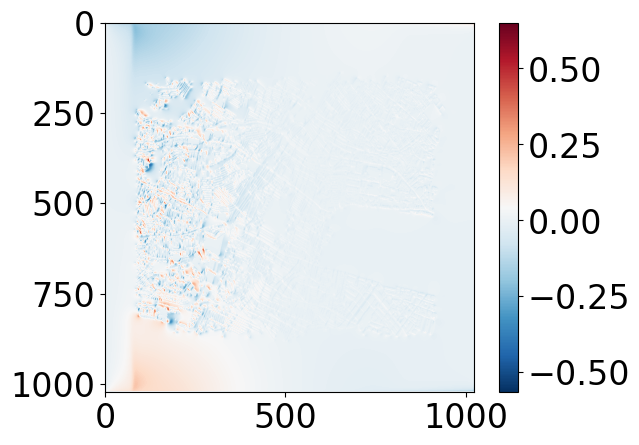

In [40]:
plt.imshow((values_v)[0,2,:,:,0], cmap='RdBu_r')
plt.colorbar()

In [145]:
np.save("scaling fiter"+str(itime), arr=mag1)
np.save("enlarging pg"+str(itime), arr=mag)

In [133]:
#    mag1 = np.load('scaling fiter4000.npy').astype('float32')
mag = np.load('enlarging pg4000.npy').astype('float32')

In [132]:
mag1 = (values_u**2+values_v**2+values_w**2)**0.5

In [35]:
mag = (values_u**2+values_v**2+values_w**2)**0.5

Text(0.5, 1.0, 'z = 30')

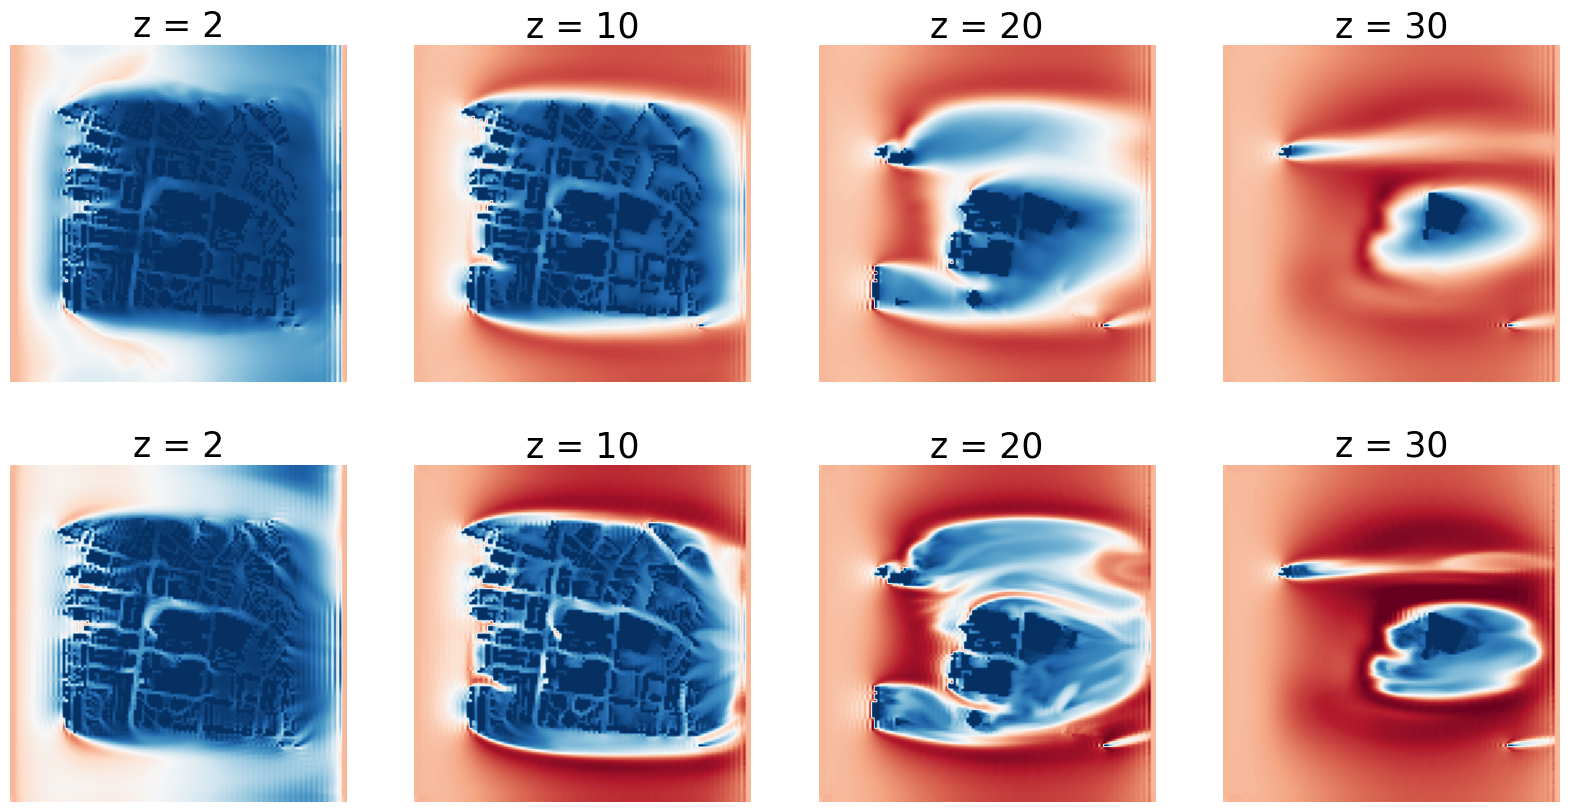

In [134]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

plt.subplot(2,4,1)
plt.imshow((mag1)[0,2,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('z = 2', fontsize=25)
plt.subplot(2,4,2)
plt.imshow((mag1)[0,10,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('z = 10', fontsize=25)
plt.subplot(2,4,3)
plt.imshow((mag1)[0,20,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('z = 20', fontsize=25)
plt.subplot(2,4,4)
plt.imshow((mag1)[0,30,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('z = 30', fontsize=25)

plt.subplot(2,4,5)
plt.imshow((mag)[0,2,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('z = 2', fontsize=25)
plt.subplot(2,4,6)
plt.imshow((mag)[0,10,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('z = 10', fontsize=25)

plt.subplot(2,4,7)
plt.imshow((mag)[0,20,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('z = 20', fontsize=25)
plt.subplot(2,4,8)
plt.imshow((mag)[0,30,:,:,0], cmap='RdBu_r', vmin=0, vmax=1.5)
# plt.colorbar()
plt.axis('off') 
plt.title('z = 30', fontsize=25)

Text(0.5, 1.0, 'Z = 30')

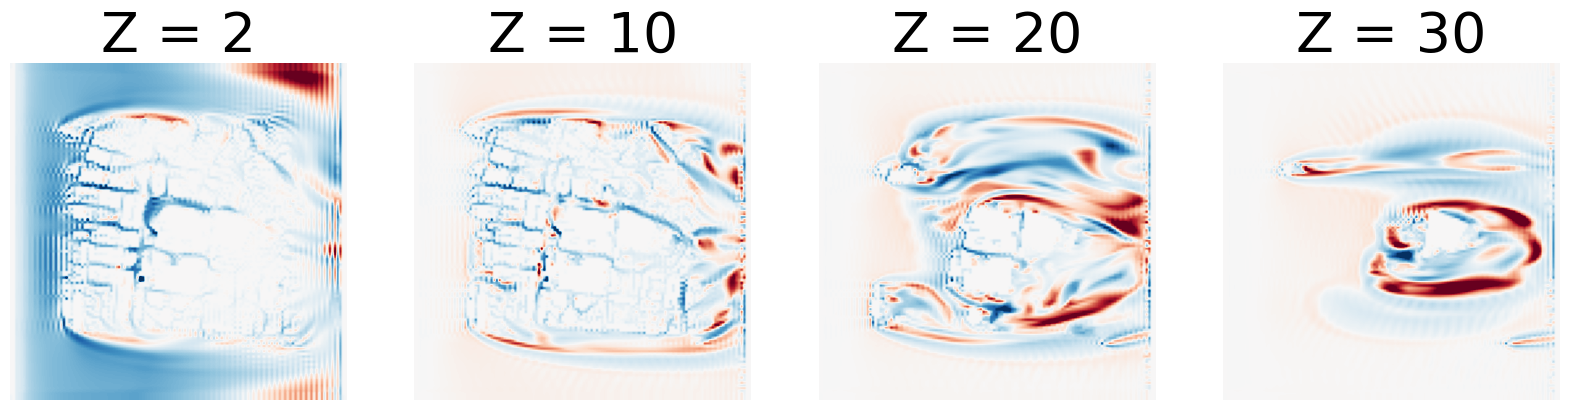

In [79]:
fig, axs = plt.subplots(1, 4, figsize=(20, 10))


plt.subplot(1,4,1)
plt.imshow((mag1-mag)[0,2,:,:,0], cmap='RdBu_r', vmin=-0.2, vmax=0.2)
# plt.colorbar()
plt.axis('off') 
plt.title('Z = 2', fontsize=40)
plt.subplot(1,4,2)
plt.imshow((mag1-mag)[0,10,:,:,0], cmap='RdBu_r', vmin=-0.2, vmax=0.2)
# plt.colorbar()
plt.axis('off') 
plt.title('Z = 10', fontsize=40)

plt.subplot(1,4,3)
plt.imshow((mag1-mag)[0,20,:,:,0], cmap='RdBu_r', vmin=-0.2, vmax=0.2)
# plt.colorbar()
plt.axis('off') 
plt.title('Z = 20', fontsize=40)
plt.subplot(1,4,4)
plt.imshow((mag1-mag)[0,30,:,:,0], cmap='RdBu_r', vmin=-0.2, vmax=0.2)
# plt.colorbar()
plt.axis('off') 
plt.title('Z = 30', fontsize=40)



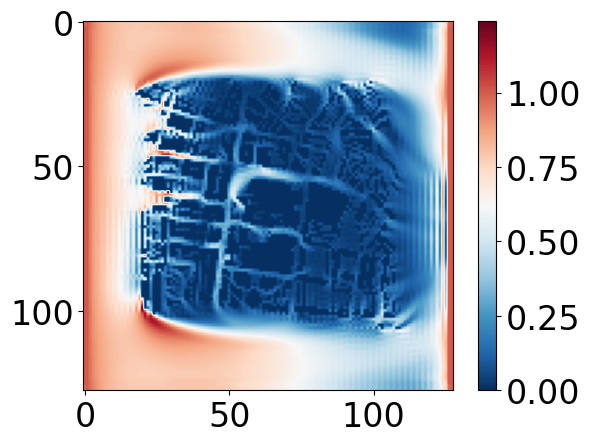

In [36]:
plt.imshow((mag)[0,2,:,:,0], cmap='RdBu_r')
plt.colorbar()

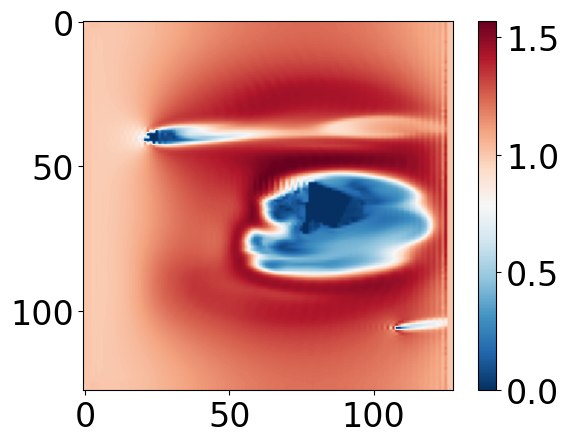

In [37]:
plt.imshow((mag)[0,30,:,:,0], cmap='RdBu_r')
plt.colorbar()

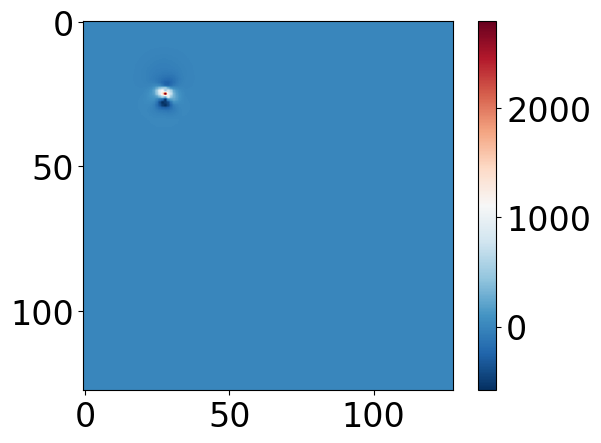

In [128]:
plt.imshow((values_p)[0,5,:,:,0], cmap='RdBu_r')
plt.colorbar()